In [11]:
from fastai.text.all import *

In [13]:
from tqdm import tqdm

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("gpt2")
neutral_model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb")
# positive_model = AutoModelForCausalLM.from_pretrained("/home/advaitmb/notebooks/projects/PreDiction/nbs/gpt2-imdb-positive-sentiment")
# negative_model = AutoModelForCausalLM.from_pretrained("/home/advaitmb/notebooks/projects/PreDiction/nbs/gpt2-imdb-negative-sentiment")
neutral_model.to('cuda')
# positive_model.to('cuda')
# negative_model.to('cuda')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [3]:
tokenizer.pad_token = tokenizer.eos_token

In [2]:
from nltk.tokenize import word_tokenize

In [3]:
def phrase_complete_api(query_text, lm):
    text = " ".join(query_text.split(" ")[-25:])
    tokenized_text = word_tokenize(text)

    # Replace hyphens as they are not handled by word_tokenize
    text = text.replace("-", " - ")
    phrase = generate_text_transformer(language_model=lm, tokenizer=tokenizer, text=text, n_words_max=5)

    # Replace full stops, commas, hyphens, slashes, inverted commas
    phrase = phrase.replace(" .", ".")
    phrase = phrase.replace(" ,", ",")
    phrase = phrase.replace(" /", "/")
    phrase = phrase.replace(" '", "'")
    phrase = phrase.replace(" - ", "-")
    phrase = phrase.replace(" n't", "n't")
    phrase = phrase.replace(" ?", "?")
    phrase = phrase.replace(" !", "!")
    phrase = phrase.replace("!", "")
    phrase = phrase.replace("?", "")
    prediction = phrase

    return prediction

In [4]:
def clean_html(raw_html):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def clean_newlines(raw_text):
    return raw_text.replace('\n', ' ')

def complete_word_transformer(language_model, tokenizer, text, final_word):
    if len(text) == 0:
        return ''
    ids = tokenizer.encode(text)
    t = torch.LongTensor(ids)[None].to('cuda')
    logits = language_model.forward(t)[0][-1][-1]
    sorted_indices = torch.argsort(logits, descending=True)
    for tk_idx in sorted_indices:
        word = tokenizer.decode([tk_idx.cpu()]).strip()
        if word.lower().startswith(final_word):
            print(final_word,sys.stderr)
            if len(word.lower()) > len(final_word):
                return word[len(final_word):]
    return ""

def generate_text_transformer(language_model, tokenizer, text, n_words_max):
    text = text.strip()

    ids = tokenizer.encode(text)
    t = torch.LongTensor(ids)[None].to('cuda')
    phrase = language_model.generate(input_ids=t, num_beams=5, temperature=1.2,  max_length=(len(ids) + 10), skip_special_tokens=True, do_sample=True, repetition_penalty=1.2)
    prediction = phrase[0][t.size(1):].cpu()
    prediction = prediction[prediction!=50256]
    return clean_newlines(clean_html(tokenizer.decode(prediction.numpy())[1:]))

In [6]:
import json 

In [8]:
f = open('../api/JSON_DATA/without_suggestions/aryasamant.10@gmail.com.json', 'rb')
json_data = f.read()

In [8]:
text = clean_newlines(pd.read_json(json_data)['text'][0])


In [9]:
a = ['i', 'am', 'the', 'best']

s = ''
for word in a:
    s = s + ' ' + word
    print(s)

 i
 i am
 i am the
 i am the best


In [10]:
a = [1,2]
b=[3,4]
a + b

[1, 2, 3, 4]

'<|endoftext|>'

In [5]:
def process_one_file(file, model, api_call_mode=False):
    raw_text = pd.read_json(open(file, 'rb').read())['text'][0]
    idx=0
    for i in range(len(raw_text)):
        if raw_text[i] == '\n':
            idx = i+1
            break
    raw_text = raw_text[idx:]
    text = clean_newlines(raw_text)
    individual_words = word_tokenize(text)
    words_completion = []
    words_actual = []
    sentence_so_far = ''
    count = 0
    if not api_call_mode:
        for word in tqdm(individual_words):
            sentence_so_far = sentence_so_far + ' ' + word
            sentence_completion = phrase_complete_api(sentence_so_far, model)
#             print(sentence_so_far)
#             print(sentence_completion)
            
            next_words = word_tokenize(sentence_completion)
            words_actual.append(word)
            words_completion = words_actual + next_words

            current_count = count_matches(words_completion, individual_words[:len(words_completion)], len(words_actual))
#             print(words_completion)
#             print(individual_words[:len(words_completion)])
#             print(current_count)
            count += current_count
    return count/len(individual_words)
        

In [ ]:
# def process_one_file(file, model, api_call_mode=False):
#     raw_text = pd.read_json(open(file, 'rb').read())['text'][0]
#     idx=0
#     for i in range(len(raw_text)):
#         if raw_text[i] == '\n':
#             idx = i+1
#             break
#     raw_text = raw_text[idx:]
#     text = clean_newlines(raw_text)
#     individual_words = word_tokenize(text)
#     words_completion = []
#     words_actual = []
#     sentence_so_far = ''
#     count = 0
#     if not api_call_mode:
#         for word in individual_words:
#             sentence_so_far = sentence_so_far + ' ' + word
            
#             next_words = word_tokenize(phrase_complete_api(sentence_so_far, model))
#             words_actual.append(word)
#             words_completion = words_actual + next_words

#             count += count_matches(words_completion, individual_words[:len(words_completion)], len(words_actual))
#     else:
#         for word in individual_words:
            

#     return count/len(individual_words)
        

In [ ]:
'The boy is going to the village'
''

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
process_one_file('../api/JSON_DATA/without_suggestions/aryasamant.10@gmail.com.json', positive_model)

 14%|█▎        | 34/250 [00:11<01:15,  2.87it/s]


KeyboardInterrupt: 

In [50]:
logging.getLogger('transformers.tokenization_utils').disabled = True

In [7]:
def count_matches(l1, l2, from_):
    count = 0
    for i in range(from_, len(l2)):
        if l1[i] == l2[i]:
            count +=1
        else:
            break
    return count

In [6]:
model_usability_metric_results = {
    'user': [],
    'model': [],
    'score_1': [],
    'score_2': [],
    'score_3': [],
    'score_4': [],
    'score_5': [],
}

In [29]:
f  = get_files('../api/JSON_DATA/without_suggestions/')[0]
str(f).split('/')[-1].replace('.json', '').strip()

'meechyash@gmail.com'

In [33]:
files = get_files('../api/JSON_DATA/without_suggestions/')
for file in files:   
    print(str(file).split('/')[-1].split('@')[0].strip())

meechyash
adwaitchandrachud13647
cmarathe1
shreyas.bal
pradhan.sonal1411
ranenihar14
pandemalvika0512
aryasamant.10


In [9]:
def process_model_usability_score(files_path, model, model_name):
    files = get_files(files_path)
    for file in files:
        model_usability_metric_results['user'].append((str(file).split('/')[-1].split('@')[0].strip()))
        model_usability_metric_results['model'].append(model_name)
        for i in range(5):
            score = process_one_file(file, model)
            model_usability_metric_results[f'score_{i+1}'].append(score)
            
            
        

In [62]:
files = get_files('../api/JSON_DATA/without_suggestions/')

In [63]:
scores1 = Parallel(n_jobs=5)(delayed(process_one_file)(files[1], negative_model) for i in tqdm(range(5)))

100%|██████████| 5/5 [00:00<00:00, 138.87it/s]


KeyboardInterrupt: 

In [ ]:
scores2 = Parallel(n_jobs=5)(delayed(process_one_file)(files[2], negative_model) for i in tqdm(range(5)))

In [ ]:
scores3 = Parallel(n_jobs=5)(delayed(process_one_file)(files[3], negative_model) for i in tqdm(range(5)))

In [ ]:
scores4 = Parallel(n_jobs=5)(delayed(process_one_file)(files[4], negative_model) for i in tqdm(range(5)))

In [ ]:
scores5 = Parallel(n_jobs=5)(delayed(process_one_file)(files[5], negative_model) for i in tqdm(range(5)))

In [ ]:
scores6 = Parallel(n_jobs=5)(delayed(process_one_file)(files[6], negative_model) for i in tqdm(range(5)))

In [ ]:
scores7 = Parallel(n_jobs=5)(delayed(process_one_file)(files[7], negative_model) for i in tqdm(range(5)))

In [ ]:
scores8 = Parallel(n_jobs=5)(delayed(process_one_file)(files[8], negative_model) for i in tqdm(range(5)))

In [38]:
process_model_usability_score('../api/JSON_DATA/without_suggestions/', positive_model, 'Positive')

 56%|█████▌    | 131/235 [00:48<00:39,  2.62it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 84%|████████▍ | 197/235 [01:14<00:15,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 12%|█▏        | 28/235 [00:09<01:19,  2.62it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 68%|██████▊   | 160/235 [00:59<00:28,  2.61it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 96%|█████████▌| 226/235 [01:24<00:03,  2.71it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 24%|██▍       | 57/235 [00:20<01:08,  2.59it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 52%|█████▏    | 123/235 [00:45<00:42,  2.63it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 80%|████████  | 189/235 [01:10<00:17,  2.59it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  9%|▊         | 20/235 [00:06<01:14,  2.88it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 65%|██████▍   | 152/235 [00:56<00:31,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 93%|█████████▎| 218/235 [01:22<00:06,  2.68it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 21%|██        | 49/235 [00:17<01:12,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 49%|████▉     | 115/235 [00:42<00:46,  2.59it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 77%|███████▋  | 181/235 [01:08<00:20,  2.61it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 41%|████      | 77/187 [00:29<00:44,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 76%|███████▋  | 143/187 [00:55<00:17,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 12%|█▏        | 22/187 [00:06<00:59,  2.78it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 82%|████████▏ | 154/187 [01:00<00:13,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 18%|█▊        | 33/187 [00:11<01:00,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 88%|████████▊ | 165/187 [01:04<00:08,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 24%|██▎       | 44/187 [00:15<00:58,  2.46it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 59%|█████▉    | 110/187 [00:42<00:30,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 94%|█████████▍| 176/187 [01:09<00:04,  2.45it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 29%|██▉       | 55/187 [00:20<00:52,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 65%|██████▍   | 121/187 [00:47<00:27,  2.39it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 25%|██▌       | 65/257 [00:23<01:12,  2.65it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 51%|█████     | 131/257 [00:50<00:50,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 77%|███████▋  | 197/257 [01:15<00:23,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 28%|██▊       | 71/257 [00:26<01:11,  2.59it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 137/257 [00:52<00:47,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 79%|███████▉  | 203/257 [01:18<00:21,  2.47it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 30%|██▉       | 77/257 [00:28<01:10,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 56%|█████▌    | 143/257 [00:54<00:44,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 81%|████████▏ | 209/257 [01:20<00:19,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  7%|▋         | 18/257 [00:05<01:23,  2.86it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 58%|█████▊    | 150/257 [00:57<00:42,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 84%|████████▍ | 216/257 [01:23<00:16,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 10%|▉         | 25/257 [00:08<01:30,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 61%|██████    | 157/257 [01:00<00:38,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 87%|████████▋ | 223/257 [01:25<00:13,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  9%|▉         | 32/342 [00:11<02:01,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 48%|████▊     | 164/342 [01:02<01:08,  2.58it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 67%|██████▋   | 230/342 [01:28<00:46,  2.41it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 87%|████████▋ | 296/342 [01:54<00:18,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  6%|▌         | 20/342 [00:06<01:52,  2.87it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 44%|████▍     | 152/342 [00:57<01:17,  2.45it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 64%|██████▎   | 218/342 [01:23<00:48,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 83%|████████▎ | 284/342 [01:49<00:22,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 21%|██▏       | 73/342 [00:26<01:44,  2.58it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 41%|████      | 139/342 [00:52<01:19,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 60%|█████▉    | 205/342 [01:18<00:51,  2.66it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 79%|███████▉  | 271/342 [01:44<00:26,  2.67it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 99%|█████████▊| 337/342 [02:09<00:01,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 18%|█▊        | 61/342 [00:21<01:46,  2.64it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 37%|███▋      | 127/342 [00:47<01:26,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 56%|█████▋    | 193/342 [01:13<00:58,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 76%|███████▌  | 259/342 [01:40<00:31,  2.62it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 95%|█████████▌| 325/342 [02:05<00:06,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 14%|█▍        | 49/342 [00:17<01:48,  2.69it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 34%|███▎      | 115/342 [00:42<01:31,  2.49it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 181/342 [01:09<01:05,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 72%|███████▏  | 247/342 [01:35<00:37,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 92%|█████████▏| 313/342 [02:00<00:11,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 26%|██▌       | 37/145 [00:12<00:40,  2.64it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 17%|█▋        | 24/145 [00:07<00:43,  2.75it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  8%|▊         | 11/145 [00:03<00:40,  3.30it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 99%|█████████▊| 143/145 [00:53<00:00,  2.62it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 44%|████▍     | 64/145 [00:22<00:31,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 90%|████████▉ | 130/145 [00:48<00:05,  2.62it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 35%|███▌      | 51/145 [00:17<00:36,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 81%|████████  | 117/145 [00:43<00:10,  2.68it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 18%|█▊        | 38/212 [00:14<01:13,  2.37it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 80%|████████  | 170/212 [01:06<00:15,  2.71it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 11%|█▏        | 24/212 [00:08<01:13,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 74%|███████▎  | 156/212 [01:01<00:21,  2.65it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 35%|███▌      | 75/212 [00:28<00:55,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 67%|██████▋   | 141/212 [00:55<00:28,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 98%|█████████▊| 207/212 [01:20<00:01,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 29%|██▉       | 61/212 [00:23<00:58,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 60%|█████▉    | 127/212 [00:50<00:34,  2.46it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 91%|█████████ | 193/212 [01:15<00:07,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 22%|██▏       | 47/212 [00:17<01:04,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 113/212 [00:44<00:39,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 84%|████████▍ | 179/212 [01:09<00:12,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 12%|█▏        | 33/286 [00:11<01:37,  2.61it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 58%|█████▊    | 165/286 [01:01<00:48,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 81%|████████  | 231/286 [01:26<00:20,  2.64it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 27%|██▋       | 76/286 [00:27<01:16,  2.74it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 50%|████▉     | 142/286 [00:52<00:51,  2.78it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 73%|███████▎  | 208/286 [01:18<00:30,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 96%|█████████▌| 274/286 [01:42<00:04,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 19%|█▉        | 54/286 [00:19<01:33,  2.47it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 42%|████▏     | 120/286 [00:44<01:00,  2.75it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 65%|██████▌   | 186/286 [01:09<00:40,  2.47it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 88%|████████▊ | 252/286 [01:34<00:12,  2.73it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 11%|█         | 32/286 [00:11<01:37,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 57%|█████▋    | 164/286 [01:00<00:48,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 80%|████████  | 230/286 [01:26<00:20,  2.68it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 26%|██▌       | 75/286 [00:27<01:19,  2.67it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 49%|████▉     | 141/286 [00:52<00:52,  2.79it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 72%|███████▏  | 207/286 [01:17<00:30,  2.58it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 95%|█████████▌| 273/286 [01:42<00:05,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 21%|██        | 53/250 [00:18<01:20,  2.43it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 48%|████▊     | 119/250 [00:44<00:52,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 74%|███████▍  | 185/250 [01:09<00:24,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 26%|██▋       | 66/250 [00:24<01:12,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 132/250 [00:49<00:46,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 79%|███████▉  | 198/250 [01:15<00:20,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  6%|▌         | 14/250 [00:04<01:13,  3.19it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 58%|█████▊    | 146/250 [00:55<00:39,  2.62it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 85%|████████▍ | 212/250 [01:21<00:14,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 11%|█         | 28/250 [00:08<01:20,  2.76it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 64%|██████▍   | 160/250 [01:00<00:34,  2.61it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 90%|█████████ | 226/250 [01:25<00:08,  2.72it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 17%|█▋        | 42/250 [00:14<01:21,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 43%|████▎     | 108/250 [00:40<00:56,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 70%|██████▉   | 174/250 [01:05<00:28,  2.64it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 96%|█████████▌| 240/250 [01:31<00:03,  2.63it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


100%|██████████| 250/250 [01:35<00:00,  2.62it/s]


In [ ]:
Writer rating
4
8
6
8
8
4
4

In [40]:
df = pd.DataFrame(model_usability_metric_results); df

user     model   score_1   score_2   score_3   score_4  \
0               meechyash  Positive  0.400000  0.412766  0.408511  0.400000   
1  adwaitchandrachud13647  Positive  0.208556  0.267380  0.288770  0.229947   
2               cmarathe1  Positive  0.249027  0.210117  0.245136  0.245136   
3             shreyas.bal  Positive  0.283626  0.295322  0.318713  0.292398   
4       pradhan.sonal1411  Positive  0.275862  0.289655  0.275862  0.234483   
5             ranenihar14  Positive  0.349057  0.334906  0.301887  0.330189   
6        pandemalvika0512  Positive  0.297203  0.265734  0.307692  0.293706   
7           aryasamant.10  Positive  0.352000  0.292000  0.320000  0.292000   

    score_5  
0  0.429787  
1  0.272727  
2  0.233463  
3  0.301170  
4  0.275862  
5  0.363208  
6  0.353147  
7  0.344000

In [ ]:
adwaitchandrachud13647@gmail.com 4
aryasamant.10@gmail.com 8
cmarathe1@gmail.com 6
meechyash@gmail.com 8
pradhan.sonal1411@gmail.com 8
ranenihar14@gmail.com 4
shreyas.bal@nid.ac.in 4

In [41]:
df['writer_ratings'] = [8, 4, 6, 4, 8, 4, None, 8]

In [43]:
df['average_score'] = (df['score_1'] + df['score_2'] + df['score_3'] + df['score_4'] + df['score_5'])/5

<AxesSubplot:xlabel='writer_ratings', ylabel='average_score'>

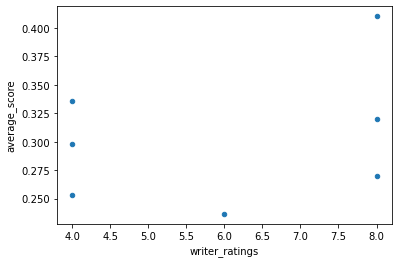

In [48]:
df.plot(x='writer_ratings', y='average_score', kind='scatter')

In [49]:
df.to_csv('positive-model-usefulness-score.csv')

In [47]:
df.plot?

In [58]:
model_usability_metric_results

{'user': ['meechyash',
  'adwaitchandrachud13647',
  'cmarathe1',
  'shreyas.bal',
  'pradhan.sonal1411',
  'ranenihar14',
  'pandemalvika0512',
  'aryasamant.10',
  'meechyash',
  'meechyash',
  'meechyash',
  'meechyash'],
 'model': ['Positive',
  'Positive',
  'Positive',
  'Positive',
  'Positive',
  'Positive',
  'Positive',
  'Positive',
  'Negative',
  'Negative',
  'Negative',
  'Negative'],
 'score_1': [0.4,
  0.20855614973262032,
  0.2490272373540856,
  0.28362573099415206,
  0.27586206896551724,
  0.3490566037735849,
  0.2972027972027972,
  0.352,
  0.3702127659574468],
 'score_2': [0.4127659574468085,
  0.26737967914438504,
  0.21011673151750973,
  0.2953216374269006,
  0.2896551724137931,
  0.33490566037735847,
  0.26573426573426573,
  0.292],
 'score_3': [0.4085106382978723,
  0.2887700534759358,
  0.245136186770428,
  0.31871345029239767,
  0.27586206896551724,
  0.3018867924528302,
  0.3076923076923077,
  0.32],
 'score_4': [0.4,
  0.22994652406417113,
  0.2451361867704

In [66]:
process_model_usability_score('../api/JSON_DATA/without_suggestions/', negative_model, 'Negative')

 56%|█████▌    | 131/235 [00:49<00:40,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 84%|████████▍ | 197/235 [01:14<00:15,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 12%|█▏        | 28/235 [00:09<01:21,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 68%|██████▊   | 160/235 [01:00<00:29,  2.58it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 96%|█████████▌| 226/235 [01:25<00:03,  2.71it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 24%|██▍       | 57/235 [00:20<01:07,  2.63it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 52%|█████▏    | 123/235 [00:45<00:42,  2.66it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 80%|████████  | 189/235 [01:10<00:17,  2.62it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  9%|▊         | 20/235 [00:06<01:15,  2.86it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 65%|██████▍   | 152/235 [00:57<00:32,  2.59it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 93%|█████████▎| 218/235 [01:22<00:06,  2.71it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 21%|██        | 49/235 [00:17<01:13,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 49%|████▉     | 115/235 [00:43<00:45,  2.63it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 77%|███████▋  | 181/235 [01:08<00:20,  2.58it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 41%|████      | 77/187 [00:29<00:46,  2.39it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 76%|███████▋  | 143/187 [00:55<00:17,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 12%|█▏        | 22/187 [00:07<00:59,  2.76it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 82%|████████▏ | 154/187 [01:00<00:13,  2.47it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 18%|█▊        | 33/187 [00:11<01:02,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 88%|████████▊ | 165/187 [01:04<00:08,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 24%|██▎       | 44/187 [00:15<00:56,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 59%|█████▉    | 110/187 [00:42<00:29,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 94%|█████████▍| 176/187 [01:08<00:04,  2.45it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 29%|██▉       | 55/187 [00:20<00:52,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 65%|██████▍   | 121/187 [00:46<00:26,  2.46it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 25%|██▌       | 65/257 [00:23<01:13,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 51%|█████     | 131/257 [00:49<00:49,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 77%|███████▋  | 197/257 [01:15<00:23,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 28%|██▊       | 71/257 [00:26<01:10,  2.62it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 137/257 [00:51<00:46,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 79%|███████▉  | 203/257 [01:17<00:21,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 30%|██▉       | 77/257 [00:28<01:11,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 56%|█████▌    | 143/257 [00:54<00:44,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 81%|████████▏ | 209/257 [01:19<00:19,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  7%|▋         | 18/257 [00:05<01:21,  2.95it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 58%|█████▊    | 150/257 [00:56<00:41,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 84%|████████▍ | 216/257 [01:22<00:15,  2.61it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 10%|▉         | 25/257 [00:08<01:29,  2.59it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 61%|██████    | 157/257 [00:59<00:38,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 87%|████████▋ | 223/257 [01:24<00:13,  2.58it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  9%|▉         | 32/342 [00:10<01:58,  2.61it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 48%|████▊     | 164/342 [01:02<01:08,  2.59it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 67%|██████▋   | 230/342 [01:28<00:46,  2.42it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 87%|████████▋ | 296/342 [01:54<00:17,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  6%|▌         | 20/342 [00:06<01:53,  2.84it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 44%|████▍     | 152/342 [00:57<01:16,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 64%|██████▎   | 218/342 [01:24<00:49,  2.49it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 83%|████████▎ | 284/342 [01:50<00:22,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 21%|██▏       | 73/342 [00:26<01:45,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 41%|████      | 139/342 [00:52<01:19,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 60%|█████▉    | 205/342 [01:19<00:53,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 79%|███████▉  | 271/342 [01:45<00:26,  2.66it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 99%|█████████▊| 337/342 [02:11<00:02,  2.49it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 18%|█▊        | 61/342 [00:22<01:48,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 37%|███▋      | 127/342 [00:47<01:27,  2.46it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 56%|█████▋    | 193/342 [01:14<00:59,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 76%|███████▌  | 259/342 [01:40<00:31,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 95%|█████████▌| 325/342 [02:06<00:06,  2.49it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 14%|█▍        | 49/342 [00:17<01:47,  2.72it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 34%|███▎      | 115/342 [00:42<01:31,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 181/342 [01:09<01:06,  2.41it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 72%|███████▏  | 247/342 [01:36<00:37,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 92%|█████████▏| 313/342 [02:01<00:11,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 26%|██▌       | 37/145 [00:12<00:41,  2.61it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 17%|█▋        | 24/145 [00:07<00:43,  2.79it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  8%|▊         | 11/145 [00:03<00:39,  3.36it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 99%|█████████▊| 143/145 [00:53<00:00,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 44%|████▍     | 64/145 [00:22<00:31,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 90%|████████▉ | 130/145 [00:48<00:05,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 35%|███▌      | 51/145 [00:18<00:36,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 81%|████████  | 117/145 [00:43<00:10,  2.64it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 18%|█▊        | 38/212 [00:13<01:11,  2.43it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 80%|████████  | 170/212 [01:06<00:15,  2.64it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 11%|█▏        | 24/212 [00:08<01:14,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 74%|███████▎  | 156/212 [01:01<00:21,  2.65it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 35%|███▌      | 75/212 [00:28<00:54,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 67%|██████▋   | 141/212 [00:54<00:27,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 98%|█████████▊| 207/212 [01:20<00:01,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 29%|██▉       | 61/212 [00:22<00:58,  2.59it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 60%|█████▉    | 127/212 [00:49<00:34,  2.47it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 91%|█████████ | 193/212 [01:15<00:07,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 22%|██▏       | 47/212 [00:17<01:05,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 113/212 [00:44<00:39,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 84%|████████▍ | 179/212 [01:09<00:12,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 12%|█▏        | 33/286 [00:11<01:35,  2.64it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 58%|█████▊    | 165/286 [01:01<00:47,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 81%|████████  | 231/286 [01:26<00:20,  2.63it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 27%|██▋       | 76/286 [00:28<01:17,  2.72it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 50%|████▉     | 142/286 [00:52<00:51,  2.78it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 73%|███████▎  | 208/286 [01:18<00:30,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 96%|█████████▌| 274/286 [01:43<00:04,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 19%|█▉        | 54/286 [00:19<01:35,  2.43it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 42%|████▏     | 120/286 [00:44<01:00,  2.73it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 65%|██████▌   | 186/286 [01:09<00:41,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 88%|████████▊ | 252/286 [01:35<00:12,  2.70it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 11%|█         | 32/286 [00:11<01:41,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 57%|█████▋    | 164/286 [01:01<00:48,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 80%|████████  | 230/286 [01:27<00:20,  2.70it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 26%|██▌       | 75/286 [00:27<01:19,  2.64it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 49%|████▉     | 141/286 [00:52<00:52,  2.76it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 72%|███████▏  | 207/286 [01:18<00:30,  2.61it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 95%|█████████▌| 273/286 [01:42<00:05,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 21%|██        | 53/250 [00:18<01:18,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 48%|████▊     | 119/250 [00:44<00:53,  2.46it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 74%|███████▍  | 185/250 [01:10<00:25,  2.58it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 26%|██▋       | 66/250 [00:24<01:13,  2.49it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 132/250 [00:50<00:46,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 79%|███████▉  | 198/250 [01:15<00:20,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  6%|▌         | 14/250 [00:04<01:15,  3.14it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 58%|█████▊    | 146/250 [00:55<00:40,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 85%|████████▍ | 212/250 [01:21<00:14,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 11%|█         | 28/250 [00:09<01:22,  2.70it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 64%|██████▍   | 160/250 [01:00<00:35,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 90%|█████████ | 226/250 [01:25<00:08,  2.74it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 17%|█▋        | 42/250 [00:14<01:21,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 43%|████▎     | 108/250 [00:40<00:54,  2.62it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 70%|██████▉   | 174/250 [01:05<00:28,  2.66it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 96%|█████████▌| 240/250 [01:31<00:03,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


100%|██████████| 250/250 [01:35<00:00,  2.62it/s]


In [67]:
df = pd.DataFrame(model_usability_metric_results); df

user     model   score_1   score_2   score_3   score_4  \
0               meechyash  Negative  0.365957  0.357447  0.340426  0.348936   
1  adwaitchandrachud13647  Negative  0.245989  0.251337  0.304813  0.294118   
2               cmarathe1  Negative  0.225681  0.229572  0.252918  0.206226   
3             shreyas.bal  Negative  0.257310  0.274854  0.286550  0.271930   
4       pradhan.sonal1411  Negative  0.255172  0.227586  0.255172  0.282759   
5             ranenihar14  Negative  0.320755  0.372642  0.367925  0.382075   
6        pandemalvika0512  Negative  0.307692  0.332168  0.353147  0.290210   
7           aryasamant.10  Negative  0.280000  0.320000  0.308000  0.280000   

    score_5  
0  0.378723  
1  0.320856  
2  0.214008  
3  0.251462  
4  0.220690  
5  0.330189  
6  0.339161  
7  0.304000

In [68]:
df['writer_ratings'] = [8, 4, 6, 4, 8, 4, None, 8]
df['average_score'] = (df['score_1'] + df['score_2'] + df['score_3'] + df['score_4'] + df['score_5'])/5
df.plot(x='writer_ratings', y='average_score', kind='scatter')

In [69]:
df['average_score'] = (df['score_1'] + df['score_2'] + df['score_3'] + df['score_4'] + df['score_5'])/5

<AxesSubplot:xlabel='writer_ratings', ylabel='average_score'>

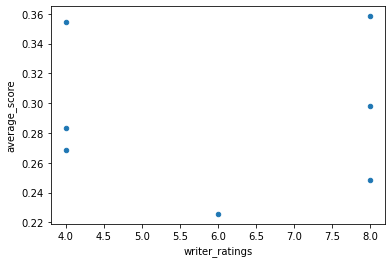

In [70]:
df.plot(x='writer_ratings', y='average_score', kind='scatter')

In [72]:
df.to_csv('negative-model-usefulness-score.csv')

In [77]:
df['average_score'].mean()

0.3035250723742846

In [76]:
df=pd.read_csv('positive-model-usefulness-score.csv')

In [14]:
process_model_usability_score('../api/JSON_DATA/without_suggestions/', neutral_model, 'Neutral')

 28%|██▊       | 65/235 [00:25<01:13,  2.32it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 56%|█████▌    | 131/235 [00:52<00:43,  2.39it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 84%|████████▍ | 197/235 [01:20<00:16,  2.32it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 12%|█▏        | 28/235 [00:10<01:26,  2.40it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 40%|████      | 94/235 [00:37<00:57,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 68%|██████▊   | 160/235 [01:04<00:31,  2.39it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 96%|█████████▌| 226/235 [01:32<00:03,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 24%|██▍       | 57/235 [00:21<01:14,  2.40it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 52%|█████▏    | 123/235 [00:49<00:45,  2.45it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 80%|████████  | 189/235 [01:16<00:18,  2.46it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  9%|▊         | 20/235 [00:06<01:18,  2.74it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 37%|███▋      | 86/235 [00:33<01:02,  2.40it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 65%|██████▍   | 152/235 [01:00<00:34,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 93%|█████████▎| 218/235 [01:27<00:06,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 21%|██        | 49/235 [00:18<01:18,  2.36it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 49%|████▉     | 115/235 [00:45<00:48,  2.47it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 77%|███████▋  | 181/235 [01:12<00:22,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  6%|▌         | 11/187 [00:03<00:57,  3.07it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 41%|████      | 77/187 [00:31<00:46,  2.34it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 76%|███████▋  | 143/187 [00:59<00:18,  2.33it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 12%|█▏        | 22/187 [00:07<01:02,  2.64it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 47%|████▋     | 88/187 [00:36<00:42,  2.31it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 82%|████████▏ | 154/187 [01:04<00:13,  2.41it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 18%|█▊        | 33/187 [00:11<01:02,  2.45it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 99/187 [00:39<00:36,  2.39it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 88%|████████▊ | 165/187 [01:06<00:09,  2.41it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 24%|██▎       | 44/187 [00:16<00:58,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 59%|█████▉    | 110/187 [00:43<00:30,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 94%|█████████▍| 176/187 [01:10<00:04,  2.42it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 29%|██▉       | 55/187 [00:20<00:55,  2.38it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 65%|██████▍   | 121/187 [00:48<00:27,  2.37it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


100%|██████████| 187/187 [01:15<00:00,  2.47it/s]


 25%|██▌       | 65/257 [00:24<01:14,  2.58it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 51%|█████     | 131/257 [00:51<00:51,  2.47it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 77%|███████▋  | 197/257 [01:17<00:23,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  2%|▏         | 5/257 [00:01<01:12,  3.47it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 28%|██▊       | 71/257 [00:26<01:13,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 137/257 [00:53<00:47,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 79%|███████▉  | 203/257 [01:19<00:22,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  4%|▍         | 11/257 [00:03<01:17,  3.16it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 30%|██▉       | 77/257 [00:29<01:12,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 56%|█████▌    | 143/257 [00:56<00:45,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 81%|████████▏ | 209/257 [01:22<00:19,  2.42it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  7%|▋         | 18/257 [00:05<01:23,  2.87it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 33%|███▎      | 84/257 [00:31<01:08,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 58%|█████▊    | 150/257 [00:57<00:43,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 84%|████████▍ | 216/257 [01:23<00:16,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 10%|▉         | 25/257 [00:08<01:30,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 35%|███▌      | 91/257 [00:34<01:05,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 61%|██████    | 157/257 [01:00<00:39,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 87%|████████▋ | 223/257 [01:26<00:13,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  9%|▉         | 32/342 [00:10<01:59,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 29%|██▊       | 98/342 [00:36<01:34,  2.58it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 48%|████▊     | 164/342 [01:02<01:11,  2.49it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 67%|██████▋   | 230/342 [01:29<00:46,  2.42it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 87%|████████▋ | 296/342 [01:55<00:17,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  6%|▌         | 20/342 [00:06<01:54,  2.81it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 25%|██▌       | 86/342 [00:31<01:40,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 44%|████▍     | 152/342 [00:58<01:16,  2.49it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 64%|██████▎   | 218/342 [01:24<00:48,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 83%|████████▎ | 284/342 [01:50<00:23,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  2%|▏         | 7/342 [00:02<01:38,  3.41it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 21%|██▏       | 73/342 [00:26<01:45,  2.54it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 41%|████      | 139/342 [00:52<01:19,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 60%|█████▉    | 205/342 [01:19<00:53,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 79%|███████▉  | 271/342 [01:46<00:27,  2.61it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 99%|█████████▊| 337/342 [02:12<00:02,  2.46it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 18%|█▊        | 61/342 [00:22<01:49,  2.58it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 37%|███▋      | 127/342 [00:48<01:26,  2.49it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 56%|█████▋    | 193/342 [01:14<00:58,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 76%|███████▌  | 259/342 [01:41<00:32,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 95%|█████████▌| 325/342 [02:07<00:06,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 14%|█▍        | 49/342 [00:17<01:47,  2.72it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 34%|███▎      | 115/342 [00:42<01:31,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 181/342 [01:09<01:07,  2.39it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 72%|███████▏  | 247/342 [01:36<00:38,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 92%|█████████▏| 313/342 [02:02<00:11,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 26%|██▌       | 37/145 [00:12<00:41,  2.63it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 71%|███████   | 103/145 [00:38<00:16,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 17%|█▋        | 24/145 [00:07<00:43,  2.76it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 62%|██████▏   | 90/145 [00:33<00:21,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  8%|▊         | 11/145 [00:03<00:40,  3.30it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 77/145 [00:28<00:26,  2.57it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 99%|█████████▊| 143/145 [00:54<00:00,  2.59it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 44%|████▍     | 64/145 [00:23<00:31,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 90%|████████▉ | 130/145 [00:49<00:05,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 35%|███▌      | 51/145 [00:18<00:37,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 81%|████████  | 117/145 [00:43<00:10,  2.65it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 18%|█▊        | 38/212 [00:14<01:14,  2.33it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 49%|████▉     | 104/212 [00:41<00:44,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 80%|████████  | 170/212 [01:07<00:15,  2.66it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 11%|█▏        | 24/212 [00:08<01:14,  2.52it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 42%|████▏     | 90/212 [00:35<00:50,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 74%|███████▎  | 156/212 [01:02<00:21,  2.65it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  4%|▍         | 9/212 [00:02<01:01,  3.33it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 35%|███▌      | 75/212 [00:29<00:56,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 67%|██████▋   | 141/212 [00:56<00:28,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 98%|█████████▊| 207/212 [01:21<00:02,  2.49it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 29%|██▉       | 61/212 [00:23<00:59,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 60%|█████▉    | 127/212 [00:50<00:34,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 91%|█████████ | 193/212 [01:16<00:07,  2.50it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 22%|██▏       | 47/212 [00:17<01:07,  2.45it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 113/212 [00:44<00:41,  2.39it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 84%|████████▍ | 179/212 [01:10<00:13,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 12%|█▏        | 33/286 [00:11<01:38,  2.58it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 35%|███▍      | 99/286 [00:37<01:10,  2.65it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 58%|█████▊    | 165/286 [01:02<00:48,  2.48it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 81%|████████  | 231/286 [01:28<00:21,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  3%|▎         | 10/286 [00:02<01:22,  3.33it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 27%|██▋       | 76/286 [00:28<01:20,  2.62it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 50%|████▉     | 142/286 [00:53<00:51,  2.77it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 73%|███████▎  | 208/286 [01:19<00:30,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 96%|█████████▌| 274/286 [01:44<00:04,  2.47it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 19%|█▉        | 54/286 [00:19<01:34,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 42%|████▏     | 120/286 [00:45<01:01,  2.68it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 65%|██████▌   | 186/286 [01:10<00:41,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 88%|████████▊ | 252/286 [01:36<00:12,  2.70it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 99%|█████████▉| 284/286 [01:48<00:00,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
 11%|█         | 32/286 [00:11<01:39,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 34%|███▍      | 98/286 [00:36<01:10,  2.67it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 57%|█████▋    | 164/286 [01:01<00:48,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 80%|████████  | 230/286 [01:27<00:21,  2.63it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  3%|▎         | 9/286 [00:02<01:24,  3.30it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 26%|██▌       | 75/286 [00:28<01:19,  2.65it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 49%|████▉     | 141/286 [00:52<00:52,  2.75it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 72%|███████▏  | 207/286 [01:18<00:31,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 95%|█████████▌| 273/286 [01:44<00:05,  2.45it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 21%|██        | 53/250 [00:19<01:22,  2.38it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 48%|████▊     | 119/250 [00:45<00:53,  2.44it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 74%|███████▍  | 185/250 [01:12<00:25,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  0%|          | 0/250 [00:00<?, ?it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 26%|██▋       | 66/250 [00:24<01:13,  2.49it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 53%|█████▎    | 132/250 [00:51<00:46,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 79%|███████▉  | 198/250 [01:17<00:21,  2.43it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  6%|▌         | 14/250 [00:04<01:14,  3.16it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 32%|███▏      | 80/250 [00:30<01:10,  2.43it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 58%|█████▊    | 146/250 [00:56<00:40,  2.56it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 85%|████████▍ | 212/250 [01:22<00:15,  2.49it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 11%|█         | 28/250 [00:09<01:22,  2.69it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 38%|███▊      | 94/250 [00:35<01:01,  2.53it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 64%|██████▍   | 160/250 [01:02<00:35,  2.51it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 90%|█████████ | 226/250 [01:28<00:09,  2.62it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 17%|█▋        | 42/250 [00:14<01:25,  2.45it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 43%|████▎     | 108/250 [00:41<00:55,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 70%|██████▉   | 174/250 [01:07<00:29,  2.60it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


 96%|█████████▌| 240/250 [01:33<00:03,  2.55it/s]Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


100%|██████████| 250/250 [01:37<00:00,  2.56it/s]


In [17]:
users = ['meechyash',
  'adwaitchandrachud13647',
  'cmarathe1',
  'shreyas.bal',
  'pradhan.sonal1411',
  'ranenihar14',
  'pandemalvika0512',
  'aryasamant.10']
models = ['Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',]

In [19]:
model_usability_metric_results['user'] = users
model_usability_metric_results['model'] = models


In [16]:
users = ['meechyash',
  'adwaitchandrachud13647',
  'cmarathe1',
  'shreyas.bal',
  'pradhan.sonal1411',
  'ranenihar14',
  'pandemalvika0512',
  'aryasamant.10']
models = ['Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',]

{'user': ['meechyash',
  'meechyash',
  'adwaitchandrachud13647',
  'cmarathe1',
  'shreyas.bal',
  'pradhan.sonal1411',
  'ranenihar14',
  'pandemalvika0512',
  'aryasamant.10'],
 'model': ['Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral'],
 'score_1': [0.4085106382978723,
  0.23529411764705882,
  0.19455252918287938,
  0.2807017543859649,
  0.3103448275862069,
  0.30660377358490565,
  0.3146853146853147,
  0.296],
 'score_2': [0.39574468085106385,
  0.2887700534759358,
  0.22178988326848248,
  0.26608187134502925,
  0.31724137931034485,
  0.3490566037735849,
  0.3321678321678322,
  0.272],
 'score_3': [0.34893617021276596,
  0.3155080213903743,
  0.22178988326848248,
  0.24561403508771928,
  0.2206896551724138,
  0.2971698113207547,
  0.27972027972027974,
  0.288],
 'score_4': [0.39574468085106385,
  0.23529411764705882,
  0.24124513618677043,
  0.260233918128655,
  0.27586206896551724,
  0.33490566037735847,
  0.286713

In [21]:
df = pd.DataFrame(model_usability_metric_results); df

user    model   score_1   score_2   score_3   score_4  \
0               meechyash  Neutral  0.408511  0.395745  0.348936  0.395745   
1  adwaitchandrachud13647  Neutral  0.235294  0.288770  0.315508  0.235294   
2               cmarathe1  Neutral  0.194553  0.221790  0.221790  0.241245   
3             shreyas.bal  Neutral  0.280702  0.266082  0.245614  0.260234   
4       pradhan.sonal1411  Neutral  0.310345  0.317241  0.220690  0.275862   
5             ranenihar14  Neutral  0.306604  0.349057  0.297170  0.334906   
6        pandemalvika0512  Neutral  0.314685  0.332168  0.279720  0.286713   
7           aryasamant.10  Neutral  0.296000  0.272000  0.288000  0.296000   

    score_5  
0  0.348936  
1  0.283422  
2  0.186770  
3  0.239766  
4  0.289655  
5  0.292453  
6  0.311189  
7  0.348000

In [22]:
df['writer_ratings'] = [8, 4, 6, 4, 8, 4, None, 8]

In [23]:
df['average_score'] = (df['score_1'] + df['score_2'] + df['score_3'] + df['score_4'] + df['score_5'])/5

<AxesSubplot:xlabel='writer_ratings', ylabel='average_score'>

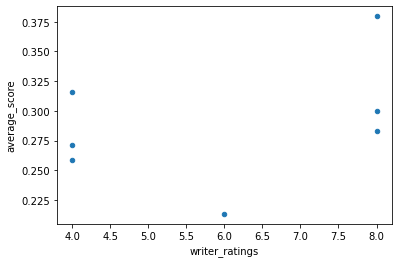

In [24]:
df.plot(x='writer_ratings', y='average_score', kind='scatter')

In [25]:
df.to_csv('neutral-model-usefulness-score.csv')

In [26]:
df['average_score'].mean()

0.29082909845972454

In [54]:
from joblib import Parallel, delayed

In [36]:
model_usability_metric_results_neutral = {
    'model': ['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral'],
    'score_1': [0.548936170212766,
  0.44385026737967914,
  0.39299610894941633,
  0.4590643274853801,
  0.4827586206896552,
  0.5047169811320755,
  0.5454545454545454,
  0.504],
    'score_2': [ 0.5659574468085107,
  0.4919786096256685,
  0.3852140077821012,
  0.48830409356725146,
  0.43448275862068964,
  0.5424528301886793,
  0.6013986013986014,
  0.552],
    'score_3': [ 0.502127659574468,
  0.45989304812834225,
  0.36186770428015563,
  0.47368421052631576,
  0.5172413793103449,
  0.4716981132075472,
  0.5734265734265734,
  0.532],
    'score_4': [  0.5276595744680851,
  0.48663101604278075,
  0.40077821011673154,
  0.5,
  0.503448275862069,
  0.5047169811320755,
  0.5034965034965035,
  0.48],
    'score_5': [ 0.5361702127659574,
  0.4117647058823529,
  0.3735408560311284,
  0.5175438596491229,
  0.5517241379310345,
  0.4386792452830189,
  0.5209790209790209,
  0.556]
}

In [37]:
model_usability_metric_results_neutral

{'model': ['Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral',
  'Neutral'],
 'score_1': [0.548936170212766,
  0.44385026737967914,
  0.39299610894941633,
  0.4590643274853801,
  0.4827586206896552,
  0.5047169811320755,
  0.5454545454545454,
  0.504],
 'score_2': [0.5659574468085107,
  0.4919786096256685,
  0.3852140077821012,
  0.48830409356725146,
  0.43448275862068964,
  0.5424528301886793,
  0.6013986013986014,
  0.552],
 'score_3': [0.502127659574468,
  0.45989304812834225,
  0.36186770428015563,
  0.47368421052631576,
  0.5172413793103449,
  0.4716981132075472,
  0.5734265734265734,
  0.532],
 'score_4': [0.5276595744680851,
  0.48663101604278075,
  0.40077821011673154,
  0.5,
  0.503448275862069,
  0.5047169811320755,
  0.5034965034965035,
  0.48],
 'score_5': [0.5361702127659574,
  0.4117647058823529,
  0.3735408560311284,
  0.5175438596491229,
  0.5517241379310345,
  0.4386792452830189,
  0.5209790209790209,
  0.556]}

In [35]:
model_usability_metric_results

{'model': ['Negative',
  'Negative',
  'Negative',
  'Negative',
  'Negative',
  'Negative',
  'Negative',
  'Negative',
  'Neutral'],
 'score_1': [0.5617021276595745,
  0.5026737967914439,
  0.42023346303501946,
  0.4853801169590643,
  0.4413793103448276,
  0.5047169811320755,
  0.5314685314685315,
  0.528,
  0.548936170212766,
  0.44385026737967914,
  0.39299610894941633,
  0.4590643274853801,
  0.4827586206896552,
  0.5047169811320755,
  0.5454545454545454,
  0.504],
 'score_2': [0.6085106382978723,
  0.44385026737967914,
  0.3852140077821012,
  0.48830409356725146,
  0.46206896551724136,
  0.5283018867924528,
  0.5384615384615384,
  0.544,
  0.5659574468085107,
  0.4919786096256685,
  0.3852140077821012,
  0.48830409356725146,
  0.43448275862068964,
  0.5424528301886793,
  0.6013986013986014,
  0.552],
 'score_3': [0.5404255319148936,
  0.5187165775401069,
  0.36964980544747084,
  0.5380116959064327,
  0.5241379310344828,
  0.4858490566037736,
  0.5804195804195804,
  0.5,
  0.50212

In [16]:
model_usability_metric_results['model'].extend(['Negative','Negative','Negative'])

In [17]:
model_usability_metric_results

{'model': ['Negative',
  'Negative',
  'Negative',
  'Negative',
  'Negative',
  'Negative',
  'Negative',
  'Negative'],
 'score_1': [0.5617021276595745,
  0.5026737967914439,
  0.42023346303501946,
  0.4853801169590643,
  0.4413793103448276,
  0.5047169811320755,
  0.5314685314685315,
  0.528],
 'score_2': [0.6085106382978723,
  0.44385026737967914,
  0.3852140077821012,
  0.48830409356725146,
  0.46206896551724136,
  0.5283018867924528,
  0.5384615384615384,
  0.544],
 'score_3': [0.5404255319148936,
  0.5187165775401069,
  0.36964980544747084,
  0.5380116959064327,
  0.5241379310344828,
  0.4858490566037736,
  0.5804195804195804,
  0.5],
 'score_4': [0.5063829787234042,
  0.5347593582887701,
  0.38132295719844356,
  0.47076023391812866,
  0.43448275862068964,
  0.5235849056603774,
  0.6713286713286714,
  0.528],
 'score_5': [0.5191489361702127,
  0.5561497326203209,
  0.36964980544747084,
  0.4444444444444444,
  0.3724137931034483,
  0.589622641509434,
  0.5244755244755245,
  0.608

In [18]:
df = pd.DataFrame(model_usability_metric_results)

In [37]:
df

model   score_1   score_2   score_3   score_4   score_5
0  Positive  0.544681  0.617021  0.578723  0.663830  0.595745
1  Positive  0.497326  0.486631  0.459893  0.449198  0.497326
2  Positive  0.451362  0.447471  0.431907  0.412451  0.416342
3  Positive  0.514620  0.523392  0.561404  0.549708  0.517544
4  Positive  0.579310  0.496552  0.641379  0.517241  0.586207
5  Positive  0.490566  0.476415  0.528302  0.523585  0.495283
6  Positive  0.611888  0.541958  0.643357  0.520979  0.583916
7  Positive  0.540000  0.656000  0.564000  0.564000  0.624000

In [19]:
df

model   score_1   score_2   score_3   score_4   score_5
0  Negative  0.561702  0.608511  0.540426  0.506383  0.519149
1  Negative  0.502674  0.443850  0.518717  0.534759  0.556150
2  Negative  0.420233  0.385214  0.369650  0.381323  0.369650
3  Negative  0.485380  0.488304  0.538012  0.470760  0.444444
4  Negative  0.441379  0.462069  0.524138  0.434483  0.372414
5  Negative  0.504717  0.528302  0.485849  0.523585  0.589623
6  Negative  0.531469  0.538462  0.580420  0.671329  0.524476
7  Negative  0.528000  0.544000  0.500000  0.528000  0.608000

In [24]:
scores = (df['score_1'] + df['score_2'] + df['score_3'] + df['score_4'] + df['score_5'])/5

In [26]:
scores.mean()

0.5016500661391188

In [27]:
df.to_csv('model_usability_metric_results_negative.csv')

In [28]:
df_pos = pd.read_csv('model_usability_metric_results.csv')

In [29]:
df = df_pos

In [30]:
scores = (df['score_1'] + df['score_2'] + df['score_3'] + df['score_4'] + df['score_5'])/5

In [31]:
scores.mean()

0.5350378143203494

In [38]:
df = pd.DataFrame(model_usability_metric_results_neutral)

In [40]:
df.to_csv('model_usability_metric_results_neutral.csv')

In [41]:
scores = (df['score_1'] + df['score_2'] + df['score_3'] + df['score_4'] + df['score_5'])/5

In [42]:
scores.mean()

0.4912159164347162

In [ ]:
df = pd.read_csv()

In [28]:
def beam_search_modified(learn, text:str, confidence:float, no_unk:bool=True, no_punct:bool=True, top_k:int=10, beam_sz:int=100, temperature:float=1.,
                    sep:str=' ', decoder=decode_spec_tokens):
    learn.model.reset()
    learn.model.eval()
    idx = learn.dls.test_dl([text]).items[0][None]
    input_idx_length = idx.size()[1]
    nodes = None
    nodes = idx.clone()
    scores = idx.new_zeros(1).float()
    if no_unk: unk_idx = learn.dls.vocab.index(UNK)
    

    with torch.no_grad():
        while(torch.exp(-scores[0])>confidence):
            with learn.no_bar(): preds,_ = learn.get_preds(dl=[(idx,)])
            
            out = torch.log(preds[0][-1].unsqueeze(0))
            if no_unk: out[:, unk_idx] = -float('Inf')
            values, indices = out.topk(top_k, dim=-1)

            scores = (-values + scores[:,None]).view(-1)
            indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
            sort_idx = scores.argsort()[:beam_sz]
            scores = scores[sort_idx]
            nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                                    indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
            nodes = nodes.view(-1, nodes.size(2))[sort_idx]            
            learn.hidden = [(h[0][:,indices_idx[sort_idx],:],h[1][:,indices_idx[sort_idx],:]) for h in learn.model[0].hidden]
            idx = nodes[:,-1][:,None]



        if temperature != 1.: scores.div_(temperature)
        node_idx = torch.multinomial(torch.exp(-scores), 1).item()
        num = learn.dls.train_ds.numericalize
        tokens = [num.vocab[i] for i in nodes[node_idx][input_idx_length:] if num.vocab[i] not in [BOS, PAD]]
        sep = learn.dls.train_ds.tokenizer.sep
        return sep.join(decoder(tokens))

In [27]:
learn_lm = load_learner('../api/5epochs_imdb_lm.pkl')

In [31]:
def phrase_complete_api(query_text, lm):
    text = " ".join(query_text.split(" ")[-25:])
    tokenized_text = word_tokenize(text)

    # Replace hyphens as they are not handled by word_tokenize
    text = text.replace("-", " - ")
#     phrase = generate_text_transformer(language_model=lm, tokenizer=tokenizer, text=text, n_words_max=5)
    phrase = beam_search_modified(learn=lm, text=query_text, confidence=0.01)
    # Replace full stops, commas, hyphens, slashes, inverted commas
    phrase = phrase.replace(" .", ".")
    phrase = phrase.replace(" ,", ",")
    phrase = phrase.replace(" /", "/")
    phrase = phrase.replace(" '", "'")
    phrase = phrase.replace(" - ", "-")
    phrase = phrase.replace(" n't", "n't")
    phrase = phrase.replace(" ?", "?")
    phrase = phrase.replace(" !", "!")
    phrase = phrase.replace("!", "")
    phrase = phrase.replace("?", "")
    prediction = phrase

    return prediction

In [38]:
learn_lm.model.cuda()

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60008, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60008, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60008, bias=True)
    (output_dp): RNNDropout()
  )
)

In [32]:
phrase_complete_api('this movie', learn_lm)

'was a good'

In [33]:
process_one_file('../api/JSON_DATA/without_suggestions/aryasamant.10@gmail.com.json', learn_lm)

100%|██████████| 250/250 [00:52<00:00,  4.78it/s]


0.288

In [39]:
process_model_usability_score('../api/JSON_DATA/without_suggestions/', learn_lm, 'LSTM')

100%|██████████| 250/250 [00:50<00:00,  4.91it/s]


In [42]:
df = pd.DataFrame(model_usability_metric_results)

In [45]:
df = df.iloc[8:, :]

In [47]:
df.to_csv('usefulness-lstm.csv')

<ipython-input-48-1320fd3ee7b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['writer_ratings'] = [8, 4, 6, 4, 8, 4, None, 8]
<ipython-input-48-1320fd3ee7b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['average_score'] = (df['score_1'] + df['score_2'] + df['score_3'] + df['score_4'] + df['score_5'])/5


<AxesSubplot:xlabel='writer_ratings', ylabel='average_score'>

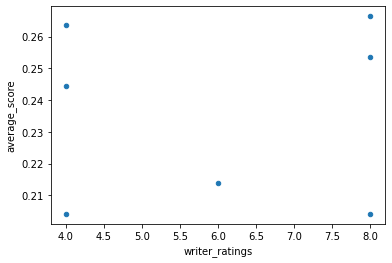

In [48]:
df['writer_ratings'] = [8, 4, 6, 4, 8, 4, None, 8]
df['average_score'] = (df['score_1'] + df['score_2'] + df['score_3'] + df['score_4'] + df['score_5'])/5
df.plot(x='writer_ratings', y='average_score', kind='scatter')

In [49]:
df['average_score'].mean()

0.23524895668088452